In [1]:
# ═══════════════════════════════════════════════
# 1. Librerías estándar y configuración general
# ═══════════════════════════════════════════════
import os
import sys
import ast
import json
import io
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

# ═══════════════════════════════════════════════
# 2. Preprocesamiento y ML clásico
# ═══════════════════════════════════════════════
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MultiLabelBinarizer,
)
from sklearn.model_selection import (
    StratifiedKFold,
    RandomizedSearchCV,
    learning_curve,
)
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    roc_curve,
)
from scipy.stats import randint, uniform

# ═══════════════════════════════════════════════
# 3. Modelos
# ═══════════════════════════════════════════════
from xgboost import XGBClassifier
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans

# ═══════════════════════════════════════════════
# 4. MLflow tracking
# ═══════════════════════════════════════════════
import mlflow
import mlflow.sklearn
mlflow.set_tracking_uri("file:../Experiments")
mlflow.set_experiment("XGBoost_Experiment")

# ═══════════════════════════════════════════════
# 5. Utilidades personalizadas / proyecto
# ═══════════════════════════════════════════════
from new_or_used import build_dataset  # función provista para cargar datos

/opt/anaconda3/envs/sumz/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

from xgboost import XGBClassifier

import mlflow
from mlflow.models.signature import infer_signature
import mlflow.sklearn

mlflow.set_tracking_uri("file:../Experiments")
mlflow.set_experiment("XGBoost_Experiment")

run_name="XGBoost"

In [3]:
# Cargar los datasets preprocesados
X_train = pd.read_csv("../Data/Gold/X_train_gold.csv")
X_test = pd.read_csv("../Data/Gold/X_test_gold.csv")
y_train = pd.read_csv("../Data/Gold/y_train_gold.csv")
y_test = pd.read_csv("../Data/Gold/y_test_gold.csv")

y_test.rename(columns={'0': 'condition'}, inplace=True)

y_train_final = y_train["condition"].map({"used": 0, "new": 1})
y_test_final = y_test["condition"].map({"used": 0, "new": 1})


print("Datasets cargados correctamente.")

Datasets cargados correctamente.


In [4]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (89998, 38)
X_test shape: (10000, 38)
y_train shape: (89998, 1)
y_test shape: (10000, 1)


# Hyperparameters XGboost

In [5]:
# === 1. Columnas categóricas y numéricas
high_card_cols = ['seller_id', 'seller_address.city.name', 'category_id']
low_card_cols = [col for col in X_train.select_dtypes(include='object').columns if col not in high_card_cols]
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# === 2. Preprocesamiento
preprocessor = ColumnTransformer([
    ("low_card_cat", OneHotEncoder(handle_unknown='ignore', sparse_output=False), low_card_cols),
    ("high_card_cat", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), high_card_cols),
    ("num", StandardScaler(), num_cols)
])

# === 3. Pipeline base
pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("classifier", XGBClassifier(eval_metric="logloss", random_state=42))
])

# === 4. Hiperparámetros a probar
param_dist = {
    "classifier__n_estimators": [200,300],
    "classifier__max_depth": [15,20, 30],
    "classifier__learning_rate": [0.1],
    "classifier__subsample": [0.5, 0.7],
    "classifier__colsample_bytree": [0.5],
    "classifier__gamma": [0, 0.3],
}



# === 5. Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# === 6. Random Search
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    scoring='accuracy',
    cv=cv,
    n_iter=20,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# === 7. MLflow Tracking
with mlflow.start_run(run_name=run_name):

    # Entrenar
    random_search.fit(X_train, y_train_final)
    best_pipeline = random_search.best_estimator_
    mlflow.log_params(random_search.best_params_)


    # === 9. Evaluar en test
    y_pred = best_pipeline.predict(X_test)
    y_prob = best_pipeline.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test_final, y_pred)
    auc = roc_auc_score(y_test_final, y_prob)

    mlflow.log_metric("accuracy", acc)
    mlflow.log_metric("roc_auc", auc)

    print(f"✅ Accuracy en test: {acc:.4f}")
    print(f"✅ ROC AUC en test: {auc:.4f}")

    # === 10. ROC Curve
    fpr, tpr, _ = roc_curve(y_test_final, y_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid()

    roc_path = "mlruns_tmp/roc_curve.png"
    plt.savefig(roc_path)
    mlflow.log_artifact(roc_path)
    plt.close()

    # === 11. Guardar modelo con MLflow
    input_example = X_train.head(3)

    mlflow.sklearn.log_model(
        best_pipeline,
        artifact_path="xgboost_pipeline",
        input_example=input_example,
        signature=mlflow.models.signature.infer_signature(input_example, best_pipeline.predict(input_example))
    )


print("✅ Modelo entrenado, evaluado y guardado con éxito.")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END classifier__colsample_bytree=0.5, classifier__gamma=0, classifier__learning_rate=0.1, classifier__max_depth=15, classifier__n_estimators=200, classifier__subsample=0.5; total time=   7.1s
[CV] END classifier__colsample_bytree=0.5, classifier__gamma=0.3, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=200, classifier__subsample=0.5; total time=   7.9s
[CV] END classifier__colsample_bytree=0.5, classifier__gamma=0.3, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=200, classifier__subsample=0.5; total time=   8.1s
[CV] END classifier__colsample_bytree=0.5, classifier__gamma=0.3, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimators=200, classifier__subsample=0.5; total time=   8.1s
[CV] END classifier__colsample_bytree=0.5, classifier__gamma=0.3, classifier__learning_rate=0.1, classifier__max_depth=20, classifier__n_estimat

/opt/anaconda3/envs/sumz/lib/python3.11/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


✅ Modelo entrenado, evaluado y guardado con éxito.


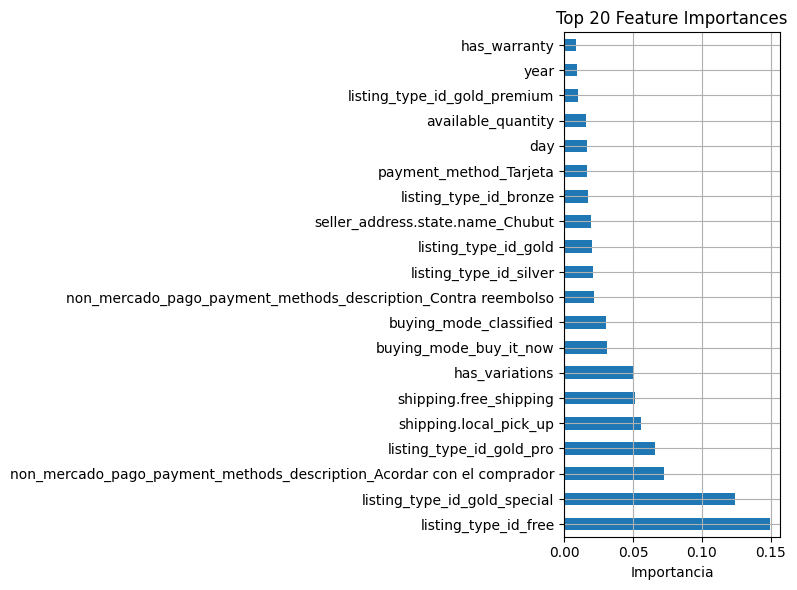

In [7]:
import matplotlib.pyplot as plt

# === 1. Obtener nombres de features
onehot_features = best_pipeline.named_steps["preprocessing"].transformers_[0][1].get_feature_names_out(low_card_cols)
all_features = list(onehot_features) + num_cols + high_card_cols  # en orden del preprocesamiento

# === 2. Obtener importancias
importancias = best_pipeline.named_steps["classifier"].feature_importances_

# === 3. Visualizar
feat_imp = pd.Series(importancias, index=all_features).sort_values(ascending=False)
feat_imp.head(20).plot(kind="barh", figsize=(8, 6))
plt.title("Top 20 Feature Importances")
plt.xlabel("Importancia")
plt.grid()
plt.tight_layout()
plt.show()